In [78]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import random
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [79]:
train=pd.read_csv('/kaggle/input/daconcard/open/train.csv')
test=pd.read_csv('/kaggle/input/daconcard/open/test.csv')
submit=pd.read_csv('/kaggle/input/daconcard/open/sample_submission.csv')

In [80]:
# train = pd.read_csv('train.csv')
train = train.drop(['index'], axis=1)
train.fillna('NAN', inplace=True) 
train['occyp_type'].loc[(train.occyp_type == 'NAN')&(train.DAYS_EMPLOYED > 0)]='Unemployed'

train.fillna('NAN', inplace=True) 
train['occyp_type'].loc[(train.occyp_type == 'NAN')&(train.DAYS_EMPLOYED < 0)]='Missing'

# test = pd.read_csv('test.csv')
test = test.drop(['index'], axis=1)
test.fillna('NAN', inplace=True)
test['occyp_type'].loc[(test.occyp_type == 'NAN')&(test.DAYS_EMPLOYED > 0)]='Unemployed'
test['occyp_type'].loc[(test.occyp_type == 'NAN')&(test.DAYS_EMPLOYED < 0)]='Missing'

In [81]:
object_col = []
for col in train.columns:
    if train[col].dtype == 'object':
        object_col.append(col)

In [82]:
enc = OneHotEncoder()
enc.fit(train.loc[:,object_col])

train_onehot_df = pd.DataFrame(enc.transform(train.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
train.drop(object_col, axis=1, inplace=True)
train = pd.concat([train, train_onehot_df], axis=1)

In [83]:
test_onehot_df = pd.DataFrame(enc.transform(test.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
test.drop(object_col, axis=1, inplace=True)
test = pd.concat([test, test_onehot_df], axis=1)

In [69]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in skf.split(train, train['credit']):
    folds.append((train_idx, valid_idx))

In [87]:
random.seed(42)
lgb_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = train.drop(['credit'],axis=1).iloc[train_idx].values, train.drop(['credit'],axis=1).iloc[valid_idx].values,\
                                         train['credit'][train_idx].values, train['credit'][valid_idx].values 
    
    params={
        'objective':'multiclass',
        'random_state':71,
        'n_estimators':1000
    }
    lgb_model = LGBMClassifier(**params)
    lgb_model.fit(X_train,y_train,
              eval_set=[(X_train, y_train),(X_test,y_test)],
              eval_metric='multi_logloss',verbose=True,
              early_stopping_rounds=10)
    lgb_models[fold]=lgb_model
    print(f'================================================================================\n\n')

====================================1============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.652377	valid_1's multi_logloss: 0.752522
[200]	training's multi_logloss: 0.56559	valid_1's multi_logloss: 0.737156
[300]	training's multi_logloss: 0.501921	valid_1's multi_logloss: 0.731843
Early stopping, best iteration is:
[348]	training's multi_logloss: 0.475822	valid_1's multi_logloss: 0.729304


====================================2============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.646476	valid_1's multi_logloss: 0.764955
[200]	training's multi_logloss: 0.560614	valid_1's multi_logloss: 0.751681
[300]	training's multi_logloss: 0.497532	valid_1's multi_logloss: 0.748007
Early stopping, best iteration is:
[281]	training's multi_logloss: 0.508566	valid_1's multi_logloss: 0.747717


====================================3====

In [71]:
xgb_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = train.drop(['credit'],axis=1).iloc[train_idx].values, train.drop(['credit'],axis=1).iloc[valid_idx].values,\
                                         train['credit'][train_idx].values, train['credit'][valid_idx].values
    params={
    'objective':'multi:softprob',
    'random_state':71,
    'n_estimators':1000
    }
    model = XGBClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric = 'mlogloss',early_stopping_rounds=30, verbose=100)
    xgb_models[fold]=model
    print(f'================================================================================\n\n')

====================================1============================================
[0]	validation_0-mlogloss:0.97436	validation_1-mlogloss:0.97758
[100]	validation_0-mlogloss:0.56747	validation_1-mlogloss:0.73381
[200]	validation_0-mlogloss:0.44779	validation_1-mlogloss:0.72234
[211]	validation_0-mlogloss:0.43764	validation_1-mlogloss:0.72251


====================================2============================================
[0]	validation_0-mlogloss:0.97304	validation_1-mlogloss:0.97925
[100]	validation_0-mlogloss:0.56072	validation_1-mlogloss:0.74882
[200]	validation_0-mlogloss:0.44335	validation_1-mlogloss:0.74027
[235]	validation_0-mlogloss:0.41306	validation_1-mlogloss:0.74266


====================================3============================================
[0]	validation_0-mlogloss:0.97442	validation_1-mlogloss:0.97858
[100]	validation_0-mlogloss:0.56273	validation_1-mlogloss:0.74339
[200]	validation_0-mlogloss:0.44721	validation_1-mlogloss:0.73763
[205]	validation_0-mlogloss:0.

In [72]:
rf_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = train.drop(['credit'],axis=1).iloc[train_idx].values, train.drop(['credit'],axis=1).iloc[valid_idx].values,\
                                         train['credit'][train_idx].values, train['credit'][valid_idx].values
    params={'n_estimators':1000,'random_state':71,'criterion':'gini','verbose':1,'class_weight':'balanced','n_jobs':-1,'oob_score':True}
    model=RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    rf_models[fold]=model
    print(f'================================================================================\n\n')

====================================1============================================


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   13.5s finished




====================================2============================================


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   13.4s finished




====================================3============================================


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   13.4s finished




====================================4============================================


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   13.4s finished




====================================5============================================


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   13.4s finished


In [73]:

svc_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = train.drop(['credit'],axis=1).iloc[train_idx].values, train.drop(['credit'],axis=1).iloc[valid_idx].values,\
                                         train['credit'][train_idx].values, train['credit'][valid_idx].values
    params={'gamma':'auto','probability':True,'random_state':71,'class_weight':'balanced','kernel':'poly','shrinking':True,'verbose':True}
    svc_model=SVC(**params)
    model.fit(X_train, y_train)
    svc_models[fold]=model
    print(f'================================================================================\n\n')

====================================1============================================


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   13.1s finished




====================================2============================================


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   13.3s finished




====================================3============================================


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   13.3s finished




====================================4============================================


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   13.2s finished




====================================5============================================


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   13.2s finished


In [76]:
## extra tree
from sklearn.ensemble import ExtraTreesClassifier

et_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = train.drop(['credit'],axis=1).iloc[train_idx].values, train.drop(['credit'],axis=1).iloc[valid_idx].values,\
                                         train['credit'][train_idx].values, train['credit'][valid_idx].values
    params={'n_estimators':1000,'random_state':71,
            'criterion':'gini','verbose':1,
            'class_weight':'balanced','n_jobs':-1,
            'oob_score':True,'bootstrap':True}
    model=ExtraTreesClassifier(**params)
    model.fit(X_train, y_train)
    et_models[fold]=model
    print(f'================================================================================\n\n')

====================================1============================================


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   10.8s finished




====================================2============================================


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   10.9s finished




====================================3============================================


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   10.7s finished




====================================4============================================


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   10.4s finished




====================================5============================================


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   10.4s finished


In [100]:
## catboost
from catboost import CatBoostClassifier

cat_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = train.drop(['credit'],axis=1).iloc[train_idx].values, train.drop(['credit'],axis=1).iloc[valid_idx].values,\
                                         train['credit'][train_idx].values, train['credit'][valid_idx].values 
    params={
        'objective':'MultiClass',
        'eval_metric':'MultiClass',
        'n_estimators':1000,
        'random_state':71,
        'auto_class_weights':'Balanced',
        'boost_from_average':False  
    }
    cat = CatBoostClassifier(**params)
    cat.fit(X_train, y_train, 
            eval_set=[(X_train, y_train),(X_valid, y_valid)], 
            early_stopping_rounds=30,
            verbose=100)
    cat_models[fold]=cat
    print(f'================================================================================\n\n')

====================================1============================================
Learning rate set to 0.114773
0:	learn: 1.0895820	test: 1.0895820	test1: 1.0896573	best: 1.0896573 (0)	total: 11.4ms	remaining: 11.4s
100:	learn: 0.9698670	test: 0.9698670	test1: 1.0136863	best: 1.0136863 (100)	total: 1.07s	remaining: 9.57s
200:	learn: 0.9060488	test: 0.9060488	test1: 0.9892715	best: 0.9889748 (196)	total: 2.14s	remaining: 8.52s
300:	learn: 0.8556618	test: 0.8556618	test1: 0.9741184	best: 0.9741184 (300)	total: 3.19s	remaining: 7.41s
400:	learn: 0.8153924	test: 0.8153924	test1: 0.9653571	best: 0.9653334 (399)	total: 4.25s	remaining: 6.35s
500:	learn: 0.7814837	test: 0.7814837	test1: 0.9594054	best: 0.9592936 (497)	total: 5.32s	remaining: 5.3s
600:	learn: 0.7504801	test: 0.7504801	test1: 0.9537349	best: 0.9536191 (599)	total: 6.36s	remaining: 4.22s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.9514883775
bestIteration = 645

Shrink model to first 646 iterations.


===

In [116]:
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += (lgb_models[fold].predict_proba(test)/30)
    submit.iloc[:,1:] += (xgb_models[fold].predict_proba(test)/30)
    submit.iloc[:,1:] += (svc_models[fold].predict_proba(test)/30)
    submit.iloc[:,1:] += (rf_models[fold].predict_proba(test)/30)
    submit.iloc[:,1:] += (et_models[fold].predict_proba(test)/30)
    submit.iloc[:,1:] += (cat_models[fold].predict_proba(test)/30)
submit.head()

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Paral

,index,0,1,2
0,26457,0.065153,0.166709,0.768137
1,26458,0.299807,0.247308,0.452884
2,26459,0.087402,0.117350,0.795247
3,26460,0.136295,0.108191,0.755514
4,26461,0.111654,0.226443,0.661903


In [117]:
submit.to_csv('20210518_ensemble(+cat_weightX).csv',index=False)

## torch

In [63]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [64]:
# train=pd.get_dummies(train,drop_first=True)
# test=pd.get_dummies(test,drop_first=True)

In [65]:
train.shape,test.shape

((26453, 18), (10000, 17))

In [67]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()

train['gender']=le.fit_transform(train['gender'])
test['gender']=le.transform(test['gender'])

train['car']=le.fit_transform(train['car'])
test['car']=le.transform(test['car'])

train['reality']=le.fit_transform(train['reality'])
test['reality']=le.transform(test['reality'])

train['income_type']=le.fit_transform(train['income_type'])
test['income_type']=le.transform(test['income_type'])

train['edu_type']=le.fit_transform(train['edu_type'])
test['edu_type']=le.transform(test['edu_type'])

train['family_type']=le.fit_transform(train['family_type'])
test['family_type']=le.transform(test['family_type'])

train['house_type']=le.fit_transform(train['house_type'])
test['house_type']=le.transform(test['house_type'])

train['occyp_type']=le.fit_transform(train['occyp_type'])
test['occyp_type']=le.transform(test['occyp_type'])

In [68]:
X=train.drop('credit',axis=1)
y=train['credit']

from sklearn.preprocessing import normalize

X=normalize(X,axis=1)
testc=test.copy()
testc=normalize(testc,axis=1)

In [69]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=71,stratify=y)

In [70]:
X_tr,X_val,y_tr,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=71,stratify=y_train)

In [71]:
X_tr,y_tr=np.array(X_tr),np.array(y_tr)
X_val,y_val=np.array(X_val),np.array(y_val)
X_test,y_test=np.array(X_test),np.array(y_test)

In [72]:
import random

def set_seed(seed,mode=None):
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False
    np.random.seed(seed)
    random.seed(seed)
    if mode=='reproductibility':
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
set_seed(71)

# def seed_torch(seed=42):
#     random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True

# seed_torch(seed=seed_value)

In [73]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_tr).float(), torch.from_numpy(y_tr).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [74]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [75]:
def get_class_distribution(obj):
    count_dict = {
        "0": 0,
        "1": 0,
        "2": 0
    }
    
    for i in obj:
        if i == 0: 
            count_dict['0'] += 1
        elif i == 1: 
            count_dict['1'] += 1
        elif i == 2: 
            count_dict['2'] += 1            
        else:
            print("Check classes.")
            
    return count_dict

class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([3.6510e-04, 1.8772e-04, 6.9353e-05])


In [76]:
class_weights_all = class_weights[target_list]

In [77]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [78]:
EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 0.0007
NUM_FEATURES = len(train.columns)-1
NUM_CLASSES = 3

In [79]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [80]:
## softmax나 relu바꾸기. 2개 일때 괜찮은. 
## 
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [81]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [82]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=17, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [83]:
# !pip install torchsummary

In [84]:
# from torchsummary import summary

# summary(model,(1,47))

In [85]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [86]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [87]:
from tqdm import tqdm

In [92]:
print("Begin training.")
EPOCHS=10
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))


    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')


  0%|          | 0/10 [00:00<?, ?it/s]

Begin training.


 10%|█         | 1/10 [00:12<01:56, 12.92s/it]

Epoch 001: | Train Loss: 1.09673 | Val Loss: 1.06675 | Train Acc: 54.625| Val Acc: 61.805


 10%|█         | 1/10 [00:15<02:22, 15.78s/it]


KeyboardInterrupt: 

In [ ]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [90]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

<AxesSubplot:>

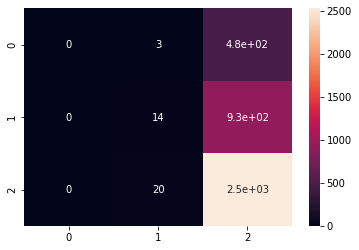

In [91]:
idx2class={0:0,1:1,2:2}

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)

sns.heatmap(confusion_matrix_df,annot=True)